In [2]:
import numpy as np
import pandas as pd
import soundfile as sf
import ffmpeg
import matplotlib.pyplot as plt
import time
from pyannote.audio import Pipeline
import torch
from os import listdir
from os.path import isfile, join
import pickle
from itertools import combinations
import sklearn
from sklearn.neighbors import KernelDensity
import scipy.stats as stats
from scipy.stats import spearmanr
import seaborn as sns

In [3]:
class Pydia:
    def __init__(self, conference, session, num_speaker):
        self.conference = conference
        self.session = session
        self.num_speaker = num_speaker
        
        self.PyDiaPath = "diarization_result/" + conference + "/"+ session
        self.diarizations = self.get_dia()
        
        
    def get_dia(self):
        onlyfiles = [join(self.PyDiaPath,f) for f in listdir(self.PyDiaPath) if isfile(join(self.PyDiaPath, f))]
        diarizations = []
        for i in range(len(onlyfiles)):
            outputName = onlyfiles[i]
            with open(outputName, "rb") as fp:
                tmp = pickle.load(fp)
            diarizations.append(tmp)
        return diarizations
    
    # TODO: Align the diarizations, can be done manually
    def offset(self):
        pass
    
    def find_intro(self, start=0, end=6000, window=400, threshold=5, given_idx=-1):
        result = []
        allspeaker, total_time, min_idx, idx, speakers, d_list = self.select_speaker(start,end,given_idx=given_idx)
        flat = self.combine_speaker(allspeaker)
        for i in range(len(flat)):
            j = i
            tmp_end_time = flat[i][0] + window 
            tmp_check = [0 for k in range(len(allspeaker))]
            tmp_speaking_time = [0 for k in range(len(allspeaker))]
            prev_speaker = flat[i][2]
            flag = 0
            while j<len(flat) and flat[j][1] < tmp_end_time:
                tmp_speaker = flat[j][2]
                tmp_check[tmp_speaker] = 1
                tmp_speaking_time[tmp_speaker] = tmp_speaking_time[tmp_speaker] + flat[j][1] - flat[j][0]
                j = j+1
                prev_speaker = tmp_speaker
                if self.check_intro(tmp_check, tmp_speaking_time, threshold=threshold):
                    result.append([flat[i][0], flat[j][1]])
                    flag = 1
                    break
            #if flag=1, we already found the intro. We need to complete the intro of last speaker.
            if flag == 1:
                while j<len(flat) and flat[j][2] == prev_speaker:
                    j = j+1
                result[-1][1] = flat[j-1][1]

        return result, min_idx, flat, d_list, allspeaker, total_time, speakers

    
    ## Functions used for find_intro (Start) 
    # ----------------------------------------------------------------------------------------- #
    def check_intro(self,tmp_check,tmp_speaking_time,threshold=5):
        if all(tmp_check):
            if min(tmp_speaking_time) > threshold:
                return True
        return False
    
    def select_speaker(self,start,end,given_idx=-1):
        speakers, times, d_list = [], [], []
        min_num = 2*self.num_speaker
        min_idx = -1
        for i in range(len(self.diarizations)):
            speaker, time, d = self.sort_speaker(self.diarizations[i],start_time=start,end_time=end)
            speakers.append(speaker)
            times.append(time)
            d_list.append(d)
            if len(time) < min_num:
                min_num, min_idx = len(time), i
        if given_idx != -1:
            return speakers[given_idx], times[given_idx], given_idx, [], speakers, d_list[given_idx][:num_speaker]
        if min_num == self.num_speaker:
            return speakers[min_idx], times[min_idx], min_idx, [], speakers, d_list[min_idx][:num_speaker]

        #vote records the most likely
        vote = [0 for i in range(min_num)]
        for i in range(len(speakers)):
            if i != min_idx:
                idx = self.check_ghost(speakers[min_idx],speakers[i],times[min_idx],times[i],self.num_speaker)
                for k in range(len(idx)):
                    vote[idx[k]] += 1
        idx = np.argpartition(vote, -min_num + self.num_speaker) 
        idx = idx[-min_num + self.num_speaker:]
            
        speaker = [i for j, i in enumerate(speakers[min_idx]) if j not in idx]
        time = [i for j, i in enumerate(times[min_idx]) if j not in idx]
        
        
        return speaker, time, min_idx, idx, speakers, d_list[min_idx][:num_speaker]
    
    def check_ghost(self,r1, r2, t1, t2, num_speaker):
        num_speaker1 = len(t1)
        num_speaker2 = len(t2)
        speaker_score = np.zeros((num_speaker1,num_speaker2))
        for i in range(num_speaker1):
            for j in range(num_speaker2):
                if t1[i] != 0 and t2[j] != 0: #check whether the speaking time is 0. Skip if speaking time is 0.
                    sum_overlap, sum_1, sum_2 = self.compare_interval(r1[i],r2[j])
                    E1 = sum_overlap/sum_1
                    E2 = sum_overlap/sum_2
                    speaker_score[i,j] = E1+E2
        best_match = speaker_score.max(axis=1)
        idx = np.argpartition(best_match, num_speaker1 - num_speaker)
        return idx[:num_speaker1 - num_speaker].astype(int)
    
    def sort_speaker(self,diarization, start_time=0, end_time=6000):
        time_window = 2
        allspeaker, total_time = self.pyannote_process(self.num_speaker, diarization, start_time, end_time, time_window)
        speaker = [x for _, x in sorted(zip(total_time, allspeaker),reverse=True)]
        time = sorted(total_time,reverse=True)
        d = sorted(range(len(total_time)), key=lambda k: total_time[k], reverse=True)
        return speaker, time, d
    
    def pyannote_process(self,num_speaker, diarization, start, end, threshold):
        intervals = [[[0,0]] for i in range(num_speaker)]
        total_times = [0 for i in range(num_speaker)]
        #print(intervals)
        for turn, _, speaker in diarization.itertracks(yield_label=True):
            temp_speaker = int(speaker.split("_")[-1])
            while temp_speaker >= len(intervals):
                intervals.append([[0,0]])
                total_times.append(0)
            #print(temp_speaker)
            if turn.start > start and turn.end < end:
                if turn.end - turn.start >= threshold:
                    intervals[temp_speaker].append([turn.start, turn.end])
                    total_times[temp_speaker] += turn.end - turn.start

        for j in range(num_speaker):
            intervals[j] = self.smooth(intervals[j], threshold)
        return intervals, total_times

    def smooth(self, interval, threshold):
        result = [interval[0]]
        prev_end = interval[0][1]
        for i in range(1,len(interval)):
            if interval[i][0] - prev_end < threshold:
                result[-1][1] = interval[i][1]
            else:
                result.append(interval[i])
            prev_end = interval[i][1]
        return result

    def combine_speaker(self, allspeaker):
        #allspeaker = allspeaker[:self.num_speaker]
        flat = []
        for i in range(len(allspeaker)):
            for segment in allspeaker[i]:
                segment_start, segment_end = segment[0], segment[1]
                if segment_end - segment_start > 0:
                    flat.append([segment_start, segment_end, i])
        flat.sort(key=lambda x: x[0])
        return flat
    
    # ----------------------------------------------------------------------------------------- #
    ##Functions used for find_intro (End)

    def match_recording(self,r1, r2, t1, t2, threshold=0.2):
        num_speaker1 = len(t1)
        num_speaker2 = len(t2)
        d = {}
        for i in range(num_speaker1):
            for j in range(num_speaker2):
                if t1[i] != 0 and t2[j] != 0: #check whether the speakering time is 0. Skip if speaking time is 0.
                    sum_overlap, sum_1, sum_2 = self.compare_interval(r1[i],r2[j])
                    E1 = 1 - sum_overlap/sum_1
                    E2 = 1 - sum_overlap/sum_2
                    if E1 + E2 < threshold:
                        d[i] = j
                        break
        return d            


    def compare_interval(self,s1,s2):
        i = 0
        j = 0
        sum_overlap = 0
        sum_i = 0
        sum_j = 0
        for k in range(len(s1)):
            sum_i += s1[k][1] - s1[k][0]
        for k in range(len(s2)):
            sum_j += s2[k][1] - s2[k][0]

        #compute overlapping intervals
        while i < len(s1) and j < len(s2):
            temp1 = s1[i]
            temp2 = s2[j]
            overlap = 0
            if temp1[0] <= temp2[0]:
                if temp1[1] <= temp2[0]: #case 5
                    i += 1
                    #print(5)
                else:
                    if temp1[1] <= temp2[1]: #case 1
                        i += 1
                        overlap = temp1[1] - temp2[0]
                        #print(1)
                    else: #case 2
                        j += 1
                        overlap = temp2[1] - temp2[0]
                        #print(2)
            else:
                if temp1[1] <= temp2[1]: #case 3
                    i += 1
                    overlap = temp1[1] - temp1[0]
                    #print(3)
                else: #case 4
                    if temp1[0] > temp2[1]: #case 6
                        j += 1
                        #print(6)
                    else: #case 4
                        j += 1
                        overlap = temp2[1] - temp1[0]
                        #print(4)
            #print(overlap,i,j)
            sum_overlap += overlap

        return sum_overlap, sum_i, sum_j 


    def select_Intro(self, start=0,end=6000,idx=0,window=400,given_idx=-1):
        intros, min_idx, flat, d_list, allspeaker, total_time, speakers = self.find_intro(start=start,end=end,window=window,given_idx=given_idx)
        if len(intros) > idx:
            intro = intros[idx]
            tmp_diarization = self.diarizations[min_idx]
            flat_2darray = np.array(flat)
            flat_2darray = flat_2darray[flat_2darray[:,0]>=intro[0]]
            flat_2darray = flat_2darray[flat_2darray[:,1]<=intro[1]]
            start_times = flat_2darray[:,0] - flat_2darray[0,0]
            end_times = flat_2darray[:,1] - flat_2darray[0,0]
            labels = flat_2darray[:,2].astype('int')
            df = pd.DataFrame()
            df['start'] = start_times
            df['end'] = end_times
            df['labels'] = labels
            df.to_excel("Intro/"+self.conference+"/"+self.session+".xlsx") 
        else:
            intro = []

        return intros, intro, min_idx, d_list, flat, allspeaker, total_time, speakers

In [4]:
class Confidence:
    def __init__(self, conference, session, num_speaker):
        self.conference = conference
        self.session = session
        self.num_speaker = num_speaker

        self.PyDiaPath = "diarization_result/" + conference + "/"+ session
        self.AmpDiaPath = "amplitude_result/" + conference + "/"+ "amplitude_"+session+".csv"
        self.AmpConfPath = "amplitude_confidence/"+conference + "/" + "ampconf_"+session+".csv"
        self.diarizations = self.get_dia() #diarizations from Pyannote

    def get_dia(self):
        onlyfiles = [join(self.PyDiaPath,f) for f in listdir(self.PyDiaPath) if isfile(join(self.PyDiaPath, f))]
        diarizations = []
        for i in range(len(onlyfiles)):
            outputName = onlyfiles[i]
            with open(outputName, "rb") as fp:
                tmp = pickle.load(fp)
            diarizations.append(tmp)
        return diarizations

    def Pyconf(self, allspeaker, total_time):
        recording_list = []
        total_times_list = []
        for i in range(len(self.diarizations)):
            tmp_speaker, tmp_total_times = self.pyannote_process(self.num_speaker, self.diarizations[i], 0, 6000, 2)
            recording_list.append(tmp_speaker)
            total_times_list.append(tmp_total_times)
        confidence_matrix, dmatrix = self.create_confidence_by_voting(recording_list, total_times_list, allspeaker, total_time)
        confidence = confidence_matrix.sum(axis=0)
        r1_flat = self.combine_speaker(allspeaker)
        return confidence, confidence_matrix, r1_flat

    ## Functions used for Pyconf (START)
    # ----------------------------------------------------------------------------------------- #
    def pyannote_process(self,num_speaker, diarization, start, end, threshold):
        intervals = [[[0,0]] for i in range(num_speaker)]
        total_times = [0 for i in range(num_speaker)]
        #print(intervals)
        for turn, _, speaker in diarization.itertracks(yield_label=True):
            temp_speaker = int(speaker.split("_")[-1])
            while temp_speaker >= len(intervals):
                intervals.append([[0,0]])
                total_times.append(0)
            #print(temp_speaker)
            if turn.start > start and turn.end < end:
                if turn.end - turn.start >= threshold:
                    intervals[temp_speaker].append([turn.start, turn.end])
                    total_times[temp_speaker] += turn.end - turn.start

        for j in range(num_speaker):
            intervals[j] = self.smooth(intervals[j], threshold)
        return intervals, total_times

    def smooth(self,interval, threshold):
        result = [interval[0]]
        prev_end = interval[0][1]
        for i in range(1,len(interval)):
            if interval[i][0] - prev_end < threshold:
                result[-1][1] = interval[i][1]
            else:
                result.append(interval[i])
            prev_end = interval[i][1]
        return result

    def create_confidence_by_voting(self,recording_list, total_times_list, allspeaker, total_time):    
        #Step 1
        num_recordings = len(recording_list)
        labels_match_diclist = []
        r1, t1 = allspeaker, total_time
        for i in range(num_recordings):
            r2, t2 = recording_list[i], total_times_list[i]
            tmp_d = self.match_recording(r1,r2,t1,t2,threshold=1)
            labels_match_diclist.append(tmp_d)


        #Step 2
        vote_matrix = []
        for i in range(num_recordings):
            r2, d = recording_list[i], labels_match_diclist[i]
            tmp_pairvote = self.check_match(r1,r2,d)
            vote_matrix.append(tmp_pairvote)

        return np.array(vote_matrix),labels_match_diclist

    def match_recording(self,r1, r2, t1, t2, threshold=0.2):
        num_speaker1 = len(t1)
        num_speaker2 = len(t2)
        d = {}
        for i in range(num_speaker1):
            for j in range(num_speaker2):
                if t1[i] != 0 and t2[j] != 0: #check whether the speakering time is 0. Skip if speaking time is 0.
                    sum_overlap, sum_1, sum_2 = self.compare_interval(r1[i],r2[j])
                    E1 = 1 - sum_overlap/sum_1
                    E2 = 1 - sum_overlap/sum_2
                    if E1 + E2 < threshold:
                        d[i] = j
                        break
        return d   


    #r1 is the reference recording which all other recordings compared to
    def check_match(self,r1,r2,d,threshold=0.2):
        #Step 1: flatten the reference recording list
        r1_flat = []
        for i in range(len(r1)):
            for segment in r1[i]:
                segment_start, segment_end = segment[0], segment[1]
                if segment_end - segment_start > 0:
                    r1_flat.append([segment_start, segment_end, i])
        r1_flat.sort(key=lambda x: x[0])


        #Step 2: check whether a segment has multiple labels
        result = [0 for i in range(len(r1_flat))] #list of 0s or 1s
        for i in range(len(r1_flat)):
            segment = r1_flat[i]
            r1_start, r1_end, r1_label = segment[0], segment[1], segment[2]
            if r1_label in d:
                r2_label = d[r1_label]
                overlap, t1, t2 = self.compare_interval([segment],r2[r2_label])
                E1 = 1 - overlap/t1
                if E1 < threshold:
                    result[i] = 1
        return result  

    def compare_interval(self,s1,s2):
        i = 0
        j = 0
        sum_overlap = 0
        sum_i = 0
        sum_j = 0
        for k in range(len(s1)):
            sum_i += s1[k][1] - s1[k][0]
        for k in range(len(s2)):
            sum_j += s2[k][1] - s2[k][0]

        #compute overlapping intervals
        while i < len(s1) and j < len(s2):
            temp1 = s1[i]
            temp2 = s2[j]
            overlap = 0
            if temp1[0] <= temp2[0]:
                if temp1[1] <= temp2[0]: #case 5
                    i += 1
                    #print(5)
                else:
                    if temp1[1] <= temp2[1]: #case 1
                        i += 1
                        overlap = temp1[1] - temp2[0]
                        #print(1)
                    else: #case 2
                        j += 1
                        overlap = temp2[1] - temp2[0]
                        #print(2)
            else:
                if temp1[1] <= temp2[1]: #case 3
                    i += 1
                    overlap = temp1[1] - temp1[0]
                    #print(3)
                else: #case 4
                    if temp1[0] > temp2[1]: #case 6
                        j += 1
                        #print(6)
                    else: #case 4
                        j += 1
                        overlap = temp2[1] - temp1[0]
                        #print(4)
            #print(overlap,i,j)
            sum_overlap += overlap

        return sum_overlap, sum_i, sum_j 

    def combine_speaker(self, allspeaker):
        #allspeaker = allspeaker[:self.num_speaker]
        flat = []
        for i in range(len(allspeaker)):
            for segment in allspeaker[i]:
                segment_start, segment_end = segment[0], segment[1]
                if segment_end - segment_start > 0:
                    flat.append([segment_start, segment_end, i])
        flat.sort(key=lambda x: x[0])
        return flat

    # ----------------------------------------------------------------------------------------- #
    ## Functions used for Pyconf (END)

    def visualize(self, r1_flat, confidence, rangeX=[0,300]):
        fig, ax1 = plt.subplots()
        color = 'tab:blue'
        for j in range(len(r1_flat)):
            ax1.hlines(y=r1_flat[j][2], xmin=r1_flat[j][0], xmax=r1_flat[j][1], linewidth=2, color=color)
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('speaker', color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xlim(rangeX)

        color = 'tab:green'
        ax2 = ax1.twinx()
        ax2.set_ylabel('confidence', color=color)
        for j in range(len(r1_flat)):
            ax2.fill_betweenx([0,(confidence[j]+1)/self.num_speaker], r1_flat[j][0], r1_flat[j][1], color=color, alpha=0.1)

        ax2.tick_params(axis='y', labelcolor=color)

        plt.grid()
        plt.show()

    def visualize_amplitude(self, diarization, confidence_curve, time, d_list, rangeX=[0,300], ENDTIME=4000, confidence_curve2=None, smooth=False, threshold=16*2):
        Amp_Intro, Amp_Intro_times = self.amplitude_process(self.num_speaker, diarization, 0, ENDTIME, 2)
        #print(Amp_Intro_MZT3_2_4)
        if smooth:
            confidence_curve = self.moving_average(np.array(confidence_curve), threshold)
            time = self.moving_average(np.array(time), threshold)
            if len(confidence_curve2) > 0:
                confidence_curve2 = self.moving_average(np.array(confidence_curve2), threshold)
        fig, ax1 = plt.subplots()
        color = 'tab:blue'
        for j in range(self.num_speaker):
            tmp_speaker = Amp_Intro[j]
            for i in range(len(tmp_speaker)):
                ax1.hlines(y=d_list[j], xmin=tmp_speaker[i][0], xmax=tmp_speaker[i][1], linewidth=2, color=color)
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('speaker', color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xlim(rangeX)

        color = 'tab:green'
        ax2 = ax1.twinx()
        ax2.set_ylabel('confidence', color=color)
        ax2.fill_between(time, confidence_curve, color=color, alpha=0.1)

        if len(confidence_curve2) > 0:
            ax2.fill_between(time, confidence_curve2, color='tab:red', alpha=0.1)

        ax2.tick_params(axis='y', labelcolor=color)

        plt.grid()
        plt.show()

    ## Functions used for visualize_amplitude (START)
    # ----------------------------------------------------------------------------------------- #	    
    def moving_average(self,x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    def amplitude_process(self,num_speaker, diarization, start, end, threshold):
        intervals = [[[0,0]] for i in range(num_speaker)]
        total_times = [0 for i in range(num_speaker)]

        for i in range(len(diarization)):
            # -1 for the index of temp_speaker because in matlab for indexing the speaker starting from 1
            turn_start, turn_end, temp_speaker = diarization[i][0], diarization[i][1], int(diarization[i][2])       

            if turn_start > start and turn_end < end:
                if turn_end - turn_start >= threshold:
                    intervals[temp_speaker].append([turn_start, turn_end])
                    total_times[temp_speaker] += turn_end - turn_start

        for j in range(num_speaker):
            intervals[j] = self.smooth(intervals[j], threshold)
        return intervals, total_times

    # ----------------------------------------------------------------------------------------- #
    ## Functions used for visualize_amplitude (END)


    def ampconf(self,d_list,rangeX=[350,400]):
        df_amplitude = pd.read_csv(self.AmpDiaPath, header=None)
        df_amplitude.rename(columns={0: 'start', 1: 'end', 2: 'label'}, inplace=True)

        df_ampconf = pd.read_csv(self.AmpConfPath, header=None)
        df_ampconf.rename(columns={0: 'conf_local', 1: 'conf_global', 2: 'conf_multi', 3: 'time'}, inplace=True)
        ampconf = df_ampconf.to_numpy()

        time = ampconf[:,3]
        confidence_curve = ampconf[:,0]/max(ampconf[:,0])
        confidence_curve2 = ampconf[:,2]/max(ampconf[:,2])

        self.visualize_amplitude(df_amplitude.to_numpy(), confidence_curve, time, d_list, rangeX=rangeX, confidence_curve2=confidence_curve2,smooth=True,threshold=16*1)

        return df_ampconf, df_amplitude

In [5]:
class Analyzer:
    def __init__(self, conference, session, num_speaker, r1_flat, confidence):
        self.conference = conference
        self.session = session
        self.num_speaker = num_speaker
        self.r1_flat = r1_flat
        self.confidence = confidence
        self.r1_flat_clean = None

        self.PyDiaPath = "diarization_result/" + conference + "/"+ session
        self.AmpDiaPath = "amplitude_result/" + conference + "/"+ "amplitude_"+session+".csv"
        self.AmpConfPath = "amplitude_confidence/"+conference + "/" + "ampconf_"+session+".csv"

        #Stats after removing the data with low confidence
        self.total_time = None #total speaking time of each speaker
        self.total_turns = None #total speaking turns of each speaker
        self.segments = None #segments of each speaker
        self.time_hist = None #histogram of length of segments
        
        #Stats before removing the data with low confidence
        self.total_time_bf = None #total speaking time of each speaker
        self.total_turns_bf = None #total speaking turns of each speaker
        self.segments_bf = None #segments of each speaker
        self.time_hist_bf = None #histogram of length of segments

    def clean_segment(self, threshold=0.5):
        r1_flat_clean = []
        for i in range(len(self.r1_flat)):
            if self.confidence[i]/self.num_speaker > threshold:
                r1_flat_clean.append(self.r1_flat[i])
        self.r1_flat_clean = r1_flat_clean
        return r1_flat_clean
    
    def stats_spk_time_before_clean(self, START=0, END=6000):
        total_time, total_turns, segments, time_hist = {}, {}, {}, {}
        for i in range(20):
            total_time[i], total_turns[i] = 0, 0
            segments[i], time_hist[i] = [], []

        for i in range(len(self.r1_flat)):
            seg_start, seg_end, seg_label = self.r1_flat[i]
            if seg_start >= START and seg_end <= END:
                if len(time_hist[seg_label])>0 and seg_label == self.r1_flat[i-1][2]:
                    total_time[seg_label] += seg_end - seg_start
                    segments[seg_label].append([seg_start,seg_end])
                    time_hist[seg_label][-1] += seg_end - seg_start
                else:
                    total_time[seg_label] += seg_end - seg_start
                    total_turns[seg_label] += 1
                    segments[seg_label].append([seg_start,seg_end])
                    time_hist[seg_label].append(seg_end - seg_start)
        
        self.total_time_bf, self.total_turns_bf, self.segments_bf, self.time_hist_bf = total_time, total_turns, segments, time_hist

        return total_time, total_turns, segments, time_hist

    def stats_spk_time(self, START=0, END=6000):
        total_time, total_turns, segments, time_hist = {}, {}, {}, {}
        for i in range(20):
            total_time[i], total_turns[i] = 0, 0
            segments[i], time_hist[i] = [], []

        for i in range(len(self.r1_flat_clean)):
            seg_start, seg_end, seg_label = self.r1_flat_clean[i]
            if seg_start >= START and seg_end <= END:
                if len(time_hist[seg_label])>0 and seg_label == self.r1_flat_clean[i-1][2]:
                    total_time[seg_label] += seg_end - seg_start
                    segments[seg_label].append([seg_start,seg_end])
                    time_hist[seg_label][-1] += seg_end - seg_start
                else:
                    total_time[seg_label] += seg_end - seg_start
                    total_turns[seg_label] += 1
                    segments[seg_label].append([seg_start,seg_end])
                    time_hist[seg_label].append(seg_end - seg_start)

        self.total_time, self.total_turns, self.segments, self.time_hist = total_time, total_turns, segments, time_hist

        return total_time, total_turns, segments, time_hist
    
    def plot_time_distribution(self):
        tmp = []
        for i in range(20):
            tmp += self.time_hist[i]
        plt.hist(tmp, bins=10)

        return
    
    def get_stats(self):
        df = pd.DataFrame(columns=['total_time', 'total_turns'])
        for i in range(20):
            if self.total_time[i] > 0:
                df = pd.concat([df,pd.DataFrame({'total_time':self.total_time[i], 'total_turns':self.total_turns[i], 
                                                 'total_time_bf_clean':self.total_time_bf[i], 
                                                'total_turns_bf_clean':self.total_turns_bf[i]},index=[i])])
        df['avg_time_per_turn'] = df['total_time']/df['total_turns']
        df['avg_time_per_turn_bf_clean'] = df['total_time_bf_clean']/df['total_turns_bf_clean']
        #reorder columns
        cols = df.columns.tolist()
        cols = cols[:2] + [cols[4]] + cols[2:4] + [cols[5]]
        df = df[cols]
        #df = df.sort_values('total_time')
        return df
    
    def get_stats_before_clean(self):
        df = pd.DataFrame(columns=['total_time', 'total_turns'])
        for i in range(20):
            if self.total_time_bf[i] > 0:
                df = pd.concat([df,pd.DataFrame({'total_time':self.total_time_bf[i], 'total_turns':self.total_turns_bf[i]},index=[i])])
        df['avg_time_per_turn'] = df['total_time']/df['total_turns']
        #df = df.sort_values('total_time')
        return df

In [6]:
session_list = ["MBC3_1_1","MBC3_1_3","MBC3_2_2","MBC3_3_1","MBC3_3_2","MBC3_3_3","MBC3_4_1","MBC3_4_2","MBC3_4_3","MBC3_5_3"]
num_speaker_list = [10,10,11,12,11,12,11,12,12,10]
start_list = [0,0,0,0,0,0,0,0,0,0]
intro_start_list = [132,134,128,134,26,290,6,155,65,87]
intro_end_list = [414,545,355,351,330,693,294,1667,800,547]
intro_idx_list = [2,0,0,0,0,0,0,0,0,0]
window_list = [400,600,400,400,400,400,400,400,400,400]
given_idx_list = [-1,-1,0,1,1,1,-1,-1,-1,-1]
facillitator_list = [[3], [1], [2,3], [5,0], [2], [0,2], [3,6], [6,2], [0,2], [0]]

session_index = [0,2,4,6,7,8,9,10,11,14]

# Adina Roskies: 0
# Adam Cohen: 1
# Martin Gruebele: 2
# Jacob Hooker: 3
# Marina Picciotto: 4
# Jacqueline Gottlieb: 5
# Mani Ramaswami: 6
# Kenneth Kosik: 7
#sort_by_facillitator = [[1], [2], [2], [3], [1], [1], [4], [4], [0,2], [4]]
#sort_by_facillitator = {0:[], 1:[0,4,5], 2:[1,2], 3:[3], 4:[6,7,9], 5:[]} #exclude the case there are two facillitator

In [7]:
df_list = []
total_end_time = []
for i in range(len(session_list)):
    conference = "MBC3"
    session = session_list[i]
    num_speaker = num_speaker_list[i]
    start = start_list[i]
    intro_start = intro_start_list[i]
    intro_end = intro_end_list[i]
    intro_idx = intro_idx_list[i]
    window = window_list[i]
    given_idx = given_idx_list[i]
    
    Pydia_test = Pydia(conference, session, num_speaker)
    #intros, intro, min_idx, d_list, flat, allspeaker, total_time, speakers = Pydia_test.select_Intro()
    intros, intro, min_idx, d_list, flat, allspeaker, total_time, speakers = Pydia_test.select_Intro(start=start,idx=intro_idx,window=window,given_idx=given_idx)
    #print(intros) #may need to choose intro from intros manually to improve performance
    
    total_end_time.append(flat[-1][1])
    
    confidence_test = Confidence(conference, session, num_speaker)
    confidence, confidence_matrix, r1_flat = confidence_test.Pyconf(allspeaker, total_time)

    analyzer_test = Analyzer(conference, session, num_speaker, flat, confidence)
    flat_clean = analyzer_test.clean_segment()
    tmp_total_time, tmp_total_turns, tmp_segments, tmp_time_hist = analyzer_test.stats_spk_time(START=intro_end)
    bf_total_time, bf_total_turns, bf_segments, bf_time_hist = analyzer_test.stats_spk_time_before_clean(START=intro_end)

    tmp_df = analyzer_test.get_stats()
    sort_by_time = tmp_df.sort_values('total_time', ascending=False)
    df_list.append(sort_by_time)
    #session_speaking_time = sort_by_time['total_time'].sum()

In [8]:
#Get personality of all participants

dfs = []

# Define a function to match total speaking time
def add_time(order):
    try:
        return df_list[i].loc[order]["total_time"]
    except:
        return None

def add_turn(order):
    try:
        return df_list[i].loc[order]["total_turns"]
    except:
        return None

for i in range(len(session_index)):
    session_id = session_index[i]
    df = pd.read_excel("NameMatch/MBC3_Name_Match_noreindex.xlsx", sheet_name=session_index[i])
    #add speaking time information to df
    df['Speaking_Time'] = df['Order'].apply(add_time)
    df['Turns'] = df['Order'].apply(add_turn)
    dfs.append(df)

# Combine all dataframes
combined_df = pd.concat(dfs, ignore_index=True)



# Group by first name and last name
personality_df = combined_df.groupby(['First Name', 'Last Name'], as_index=False)[['Speaking_Time','Turns']].mean()

# Rename columns for better readability
personality_df['Name'] = personality_df['First Name'] + " " + personality_df["Last Name"]
personality_df['active'] = personality_df['Speaking_Time']/max(personality_df['Speaking_Time'])
personality_df['Turns'] = personality_df['Turns'].round().astype("Int64")
#print(personality_df)

#PL_dict = personality_df.set_index('Name')['PL'].to_dict()
active_dict = personality_df.set_index('Name')['active'].to_dict()
#print(PH_dict)

In [9]:
inputdir = "pairsoutput/MBC2/"

filename = "MBC2_personality.pkl"
with open(inputdir + filename, 'rb') as file:
    MBC2_personality = pickle.load(file)


MBC2_personality.rename(columns={'active': 'MBC2_active', 'Speaking_Time': 'MBC2_Speaking_Time'}, inplace=True)
MBC2_personality.drop('First Name', axis=1, inplace=True)
MBC2_personality.drop('Last Name', axis=1, inplace=True)
MBC3_personality = personality_df.dropna()
MBC3_personality.drop('First Name', axis=1, inplace=True)
MBC3_personality.drop('Last Name', axis=1, inplace=True)
MBC3_personality.rename(columns={'active': 'MBC3_active', 'Speaking_Time': 'MBC3_Speaking_Time'}, inplace=True)
merge_personality = pd.merge(MBC2_personality, MBC3_personality, on='Name')

merge_personality['MBC2_active_Order'] = merge_personality['MBC2_active'].rank(method='dense', ascending=False).astype(int)
merge_personality['MBC3_active_Order'] = merge_personality['MBC3_active'].rank(method='dense', ascending=False).astype(int)
merge_personality = merge_personality[['Name', 'MBC2_Speaking_Time', 'MBC2_active', 'MBC3_Speaking_Time', 'MBC3_active', 'MBC2_active_Order', 'MBC3_active_Order']]



In [10]:
merge_personality_dict = merge_personality.set_index('Name')['MBC2_Speaking_Time'].to_dict()

In [11]:
MBC3_list = dfs
for i in range(len(MBC3_list)):
    MBC3_list[i]['Name'] = MBC3_list[i]['First Name'] + ' ' + MBC3_list[i]['Last Name']

In [13]:
len(MBC3_list)

10

In [15]:
MBC3_list[5]

,First Name,Last Name,Order,Speaking_Time,Turns,Name
0,William,Gilpin,NaN,NaN,NaN,William Gilpin
1,Antonio,Fernandez-Ruiz,4.0,296.740238,9.0,Antonio Fernandez-Ruiz
2,Sarah,Kostinski,6.0,236.146010,9.0,Sarah Kostinski
3,Christopher,Krupenye,9.0,NaN,NaN,Christopher Krupenye
4,James,Gaynor,7.0,150.509338,7.0,James Gaynor
5,Tomás,Ryan,1.0,487.113752,12.0,Tomás Ryan
6,Jean-Paul,Noel,3.0,270.271647,7.0,Jean-Paul Noel
7,Lucas,Pinto,10.0,36.825127,2.0,Lucas Pinto
8,Jessica,Bernard,8.0,111.443124,2.0,Jessica Bernard
9,Robert,Wilson,5.0,228.607810,3.0,Robert Wilson


### Random relabel interval

In [34]:
import random
N=100
random_df_list = [[] for _ in range(N)]

for i in range(len(session_list)):
    conference = "MBC3"
    session = session_list[i]
    num_speaker = num_speaker_list[i]
    start = start_list[i]
    intro_start = intro_start_list[i]
    intro_end = intro_end_list[i]
    intro_idx = intro_idx_list[i]
    window = window_list[i]
    given_idx = given_idx_list[i]
    
    Pydia_test = Pydia(conference, session, num_speaker)
    #intros, intro, min_idx, d_list, flat, allspeaker, total_time, speakers = Pydia_test.select_Intro()
    intros, intro, min_idx, d_list, flat, allspeaker, total_time, speakers = Pydia_test.select_Intro(start=start,idx=intro_idx,window=window,given_idx=given_idx)
    #print(intros) #may need to choose intro from intros manually to improve performance
    
    confidence_test = Confidence(conference, session, num_speaker)
    confidence, confidence_matrix, r1_flat = confidence_test.Pyconf(allspeaker, total_time)

    analyzer_test = Analyzer(conference, session, num_speaker, flat, confidence)
    flat_clean = analyzer_test.clean_segment()
    
    labels = list({row[2] for row in analyzer_test.r1_flat_clean})
    
    for trail in range(N):
        analyzer_test.r1_flat_clean = [[start, end, random.choice(labels)] for start, end, _ in analyzer_test.r1_flat_clean]

        tmp_total_time, tmp_total_turns, tmp_segments, tmp_time_hist = analyzer_test.stats_spk_time(START=intro_end)
        bf_total_time, bf_total_turns, bf_segments, bf_time_hist = analyzer_test.stats_spk_time_before_clean(START=intro_end)

        tmp_df = analyzer_test.get_stats()
        sort_by_time = tmp_df.sort_values('total_time', ascending=False)
        random_df_list[trail].append(sort_by_time)



In [35]:
random_dfs = [[] for _ in range(N)]

# Define a function to match total speaking time
def add_time(order):
    try:
        return random_df_list[trail][i].loc[order]["total_time"]
    except:
        return None

def add_turn(order):
    try:
        return random_df_list[trail][i].loc[order]["total_turns"]
    except:
        return None

for i in range(len(session_index)):
    session_id = session_index[i]
    df = pd.read_excel("NameMatch/MBC3_Name_Match_noreindex.xlsx", sheet_name=session_index[i])
    #add speaking time information to df
    for trail in range(N):
        df['Speaking_Time'] = df['Order'].apply(add_time)
        df['Turns'] = df['Order'].apply(add_turn)
        random_dfs[trail].append(df)

### Creating c_l from MBC3 data

In [26]:
cl44 = pd.read_csv('cl44.csv',header=None)
cl44 = cl44.values.ravel()
cl44 = np.concatenate([cl44, np.zeros(3)])

In [27]:
cl44

array([0.57892774, 0.58569596, 0.59265433, 0.59981248, 0.60718074,
       0.61477022, 0.62259289, 0.63066169, 0.63899059, 0.64759475,
       0.65649059, 0.66569602, 0.67523052, 0.6851154 , 0.69537401,
       0.70603198, 0.71711755, 0.72866188, 0.74069954, 0.7532689 ,
       0.76641279, 0.78017916, 0.7946219 , 0.80980183, 0.82578795,
       0.84265888, 0.86050471, 0.87942929, 0.89955307, 0.92101676,
       0.94398596, 0.96865727, 0.99526629, 1.02409827, 1.05550277,
       1.08991382, 1.12787867, 1.17009947, 1.2174958 , 1.27130137,
       1.3332199 , 1.40568881, 1.49235261, 1.59897957, 0.        ,
       0.        , 0.        ])

In [30]:
sorted_personality = personality_df.sort_values(by='active').reset_index(drop=True)
sorted_personality['cl'] = cl44
new_cl_dict = sorted_personality.set_index('Name')['cl'].to_dict()

In [34]:
for i in range(15):
    df = pd.read_excel('Data/prediction/MBC3_avgdynamical_result.xlsx', sheet_name=i)
    df['cl'] = df['Name'].map(new_cl_dict)
    df['cl'].to_csv('Data/cl_mbc3_44/'+str(i)+'.csv', index=False, header=False)
    

### Compare prediction and real data

In [17]:
Model_list = []
for i in range(15):
    #df = pd.read_excel('Data/prediction/realMBC3_stochastic_powerlaw_result.xlsx', sheet_name=i) #Using MBC3 data, stochastic, no need to avg over I.C.
    #df = pd.read_excel('Data/prediction/realMBC3_powerlaw_result.xlsx', sheet_name=i) #not used
    #df = pd.read_excel('Data/prediction/realMBC3_avgdeterministic_powerlaw_result.xlsx', sheet_name=i) #Using MBC3 data, deterministic, avg over I.C.
    #df = pd.read_excel('Data/prediction/MBC3/MBC3_avgpowerlaw_result_withid.xlsx', sheet_name=i) #not used, using MBC2 dagta, dynmical only avg over I.C.
    #df = pd.read_excel('Data/prediction/MBC3/MBC3_powerlaw_result_withid.xlsx', sheet_name=i) #dynamical, preregisted
    #df = pd.read_excel('Data/prediction/MBC3/MBC3_powerlaw_result_compare_stochastic.xlsx', sheet_name=i) #stochastic, preregisted
    df = pd.read_excel('Data/prediction/MBC3_avgdynamical_result.xlsx', sheet_name=i) #using MBC2 data, dynamical averaged over I.C. and cl
    #df = pd.read_excel('Data/prediction/MBC3_avgstochastic_result.xlsx', sheet_name=i) #using MBC2 data, stochastic averaged over cl
    
    Model_list.append(df)

Speaking_time_result_list = []
for i in range(len(session_index)):
    session_id = session_index[i]
    Speaking_time_compare = pd.merge(Model_list[session_id], MBC3_list[i], on='Name')
    Speaking_time_compare = Speaking_time_compare[['Name', 'cl', 'Speaking_Time', 'Model Time','Order_x']]
    tmp_total_spk_time = Speaking_time_compare['Speaking_Time'].sum()
    
    Speaking_time_compare['Real Time'] = Speaking_time_compare['Speaking_Time']/tmp_total_spk_time
    #speaking time for random null model
    Speaking_time_compare['Random Time'] = np.random.permutation(Speaking_time_compare['Real Time'].values)
    Speaking_time_compare['Random Time'] = Speaking_time_compare['Random Time'].fillna(0)
    
    Speaking_time_compare['Guess Time'] = Speaking_time_compare['Name'].map(merge_personality_dict)
    Speaking_time_compare['Guess Time'] = Speaking_time_compare['Guess Time']/tmp_total_spk_time
    Speaking_time_compare.dropna(inplace=True)
    Speaking_time_result_list.append(Speaking_time_compare)
    
merge_speaking_time_real = pd.concat(Speaking_time_result_list, axis=0, ignore_index=True)

#for stochastic
Speaking_Time_synthetic_list = []
for i in range(len(Speaking_time_result_list)):
    tmp_df1 = Speaking_time_result_list[i].rename(columns={"Model Time": "Synthetic Time"})
    tmp_df1['Synthetic Rank'] = tmp_df1['Synthetic Time'].rank(method='dense', ascending=False).astype(int)
    tmp_df1['Real Rank'] = tmp_df1['Real Time'].rank(method='dense', ascending=False).astype(int)
    tmp_df1['Guess Rank'] = tmp_df1['Guess Time'].rank(method='dense', ascending=False).astype(int)
    Speaking_Time_synthetic_list.append(tmp_df1)
    
merge_synthetic_time = pd.concat(Speaking_Time_synthetic_list, axis=0, ignore_index=True)

In [35]:
# for data corrected by cl44 (real dataset)
Model_list = []
for i in range(15):
    df = pd.read_excel('Data/prediction/MBC3_cl44stochastic_result.xlsx', sheet_name=i) #using MBC2 data, dynamical averaged over I.C. and cl    
    Model_list.append(df)

Speaking_time_result_list = []
for i in range(len(session_index)):
    session_id = session_index[i]
    Speaking_time_compare = pd.merge(Model_list[session_id], MBC3_list[i], on='Name')
    Speaking_time_compare = Speaking_time_compare[['Name', 'cl', 'Speaking_Time', 'Model Time','Order_x']]
    tmp_total_spk_time = Speaking_time_compare['Speaking_Time'].sum()
    
    Speaking_time_compare['Real Time'] = Speaking_time_compare['Speaking_Time']/tmp_total_spk_time
    #speaking time for random null model
    Speaking_time_compare['Random Time'] = np.random.permutation(Speaking_time_compare['Real Time'].values)
    Speaking_time_compare['Random Time'] = Speaking_time_compare['Random Time'].fillna(0)
    
    Speaking_time_compare['Guess Time'] = Speaking_time_compare['Name'].map(merge_personality_dict)
    Speaking_time_compare['Guess Time'] = Speaking_time_compare['Guess Time']/tmp_total_spk_time
    Speaking_time_compare.dropna(inplace=True)
    Speaking_time_result_list.append(Speaking_time_compare)
    
merge_speaking_time_real = pd.concat(Speaking_time_result_list, axis=0, ignore_index=True)

#for stochastic
Speaking_Time_synthetic_list = []
for i in range(len(Speaking_time_result_list)):
    tmp_df1 = Speaking_time_result_list[i].rename(columns={"Model Time": "Synthetic Time"})
    tmp_df1['Synthetic Rank'] = tmp_df1['Synthetic Time'].rank(method='dense', ascending=False).astype(int)
    tmp_df1['Real Rank'] = tmp_df1['Real Time'].rank(method='dense', ascending=False).astype(int)
    tmp_df1['Guess Rank'] = tmp_df1['Guess Time'].rank(method='dense', ascending=False).astype(int)
    Speaking_Time_synthetic_list.append(tmp_df1)
    
merge_synthetic_time = pd.concat(Speaking_Time_synthetic_list, axis=0, ignore_index=True)

### create plot for rank prediction

In [96]:
diff_model = abs(merge_synthetic_time["Real Rank"] - merge_synthetic_time['Synthetic Rank'])
diff_model = diff_model.value_counts().sort_index().to_list()
#diff_guess = abs(df_combined["Real Rank"] - df_combined['Guess Rank'])
#diff_guess = diff_guess.value_counts().sort_index().to_list()
print(diff_model)
diff_model.append(0)
diff_model.append(0)
#diff_guess.append(0)
#diff_guess.append(0)

[18, 18, 6, 2]


In [13]:
#shuffle speaking id
sample_kendall = []
sample_spearman = []

data_sets = []
bins = np.linspace(-0.5, 5.5, 7)
for i in range(10000):
    tmp = merge_synthetic_time["Real Rank"].sample(frac=1).reset_index(drop=True)
    sample_kendall.append(stats.kendalltau(tmp, merge_synthetic_time["Real Rank"]).statistic)
    sample_spearman.append(spearmanr(tmp, merge_synthetic_time["Real Rank"]).statistic)
    data_sets.append(abs(merge_synthetic_time["Real Rank"] - tmp))
# Compute histogram counts for each dataset
histograms = [np.histogram(data, bins=bins)[0] for data in data_sets]

# Convert list of histograms to a 2D numpy array for easy manipulation
hist_array = np.array(histograms)

# Calculate mean and standard deviation for each bin
mean_counts = hist_array.mean(axis=0)
std_dev_counts = hist_array.std(axis=0)
for i in range(len(hist_array[0])):
    hist_array[:,i] = sorted(hist_array[:,i])
mean_count = hist_array[5000,:]
#yminus = abs(hist_array.min(axis=0) - mean_counts)
#yplus = abs(hist_array.max(axis=0) - mean_counts)
yminus = abs(hist_array[250,:] - mean_count)
yplus = abs(hist_array[9750,:] - mean_count)

sample_kendall = np.array(sorted(sample_kendall))
sample_spearman = np.array(sorted(sample_spearman))
kendall_mean, spearman_mean = sample_kendall.mean(), sample_spearman.mean()
kendall_minus, spearman_minus = sample_kendall[250], sample_spearman[250]
kendall_plus, spearman_plus = sample_kendall[9750], sample_spearman[9750]

In [ ]:
#random assign speaker id for each interval


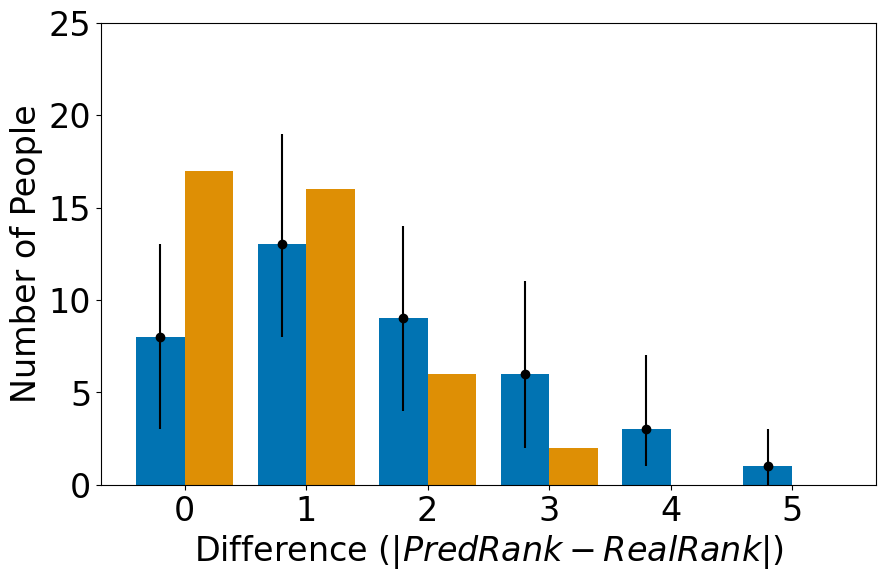

In [14]:
sns.set_palette("colorblind")
plt.figure(figsize=(10, 6))
x = range(6)  # Number of rows
bar_width = 0.4
x_positions = [
    [pos - 0.5 * bar_width for pos in x],  # First set of bars (leftmost)
    #[pos for pos in x],  # Second set of bars
    [pos + 0.5 * bar_width for pos in x]
]

#plt.bar(x_positions[0], allteam3.iloc[:, 3], width=bar_width, label='Null') 
#plt.errorbar(x_positions[0], allteam3.iloc[:, 3], error, capsize=3, fmt="bo", ecolor = "black")


plt.bar(x_positions[0], mean_count, width=bar_width, label='Null')
plt.errorbar(x_positions[0], mean_count, yerr=np.array([yminus, yplus]), fmt='bo', color='black', label='Error (std dev)')
plt.bar(x_positions[1], diff_model, width=bar_width, label='Model')
#plt.bar(x_positions[2], diff_guess, width=bar_width, label='year2')

# Plot a histogram of the difference
plt.xlabel('Difference ($|PredRank - RealRank$|)', fontsize=24)
plt.ylabel('Number of People', fontsize=24)
plt.ylim([0,25])
#plt.title('Rank Difference', fontsize=20)
#plt.legend(['Dynamical Model', 'Random'], fontsize=16)
plt.xticks(fontsize=24)  # X-axis tick font size
plt.yticks(fontsize=24)  # Y-axis tick font size
#plt.savefig("plots/Preregistration_RankDiff_new.pdf", format='pdf', bbox_inches="tight")
plt.show()

In [37]:
stats.kendalltau(merge_synthetic_time['Real Rank'], merge_synthetic_time['Synthetic Rank']).statistic

0.8100128369704749

In [38]:
spearmanr(merge_synthetic_time['Real Rank'], merge_synthetic_time['Synthetic Rank']).statistic

0.8769643119400793

### create plot for time prediction

In [39]:
#pearson correlation
y = merge_synthetic_time['Synthetic Time']
x = merge_synthetic_time['Real Time']

corr_model_synthetic = np.corrcoef(x, y)

print(corr_model_synthetic[0,1])

0.8544200625849857


In [40]:
#RMSE
np.sqrt(np.sum((merge_synthetic_time['Synthetic Time'] - merge_synthetic_time['Real Time']) ** 2)/len(merge_synthetic_time['Real Time']))


0.04220688475075738

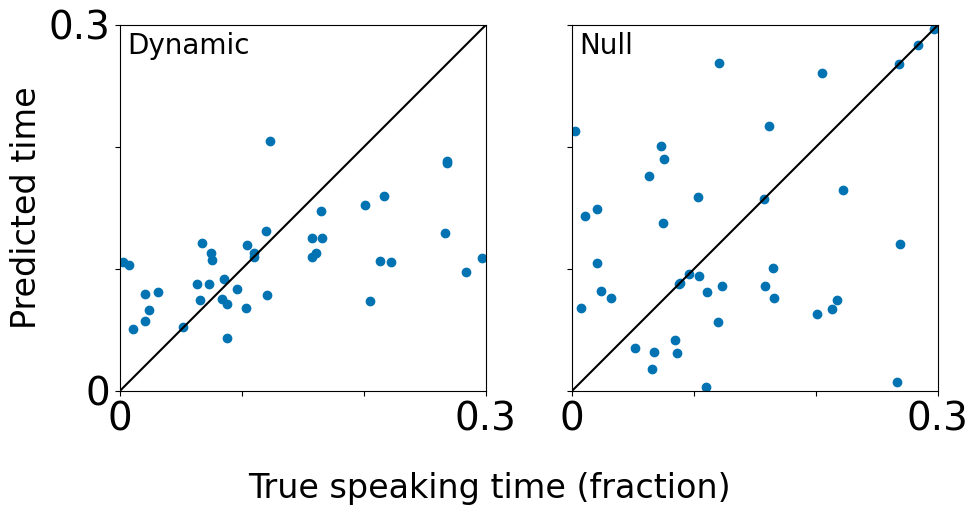

In [17]:

import matplotlib.ticker as ticker
#compare model, random
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
def make_formatter(ax):
    def formatter(x_val, pos):
        # Get current tick positions for the axis
        ticks = ax.get_xticks()
        # Return label only if the tick is close to the first or last tick value
        if np.isclose(x_val, ticks[0]):
            return f'{ticks[0]:.0f}'
        elif np.isclose(x_val, ticks[-1]):
            return f'{ticks[-1]:.1f}'
        else:
            return ''
    return formatter

# Plot data and set the custom formatter for each subplot
for ax, y in zip(axes, [merge_synthetic_time['Synthetic Time'], merge_synthetic_time['Random Time']]):
    ax.scatter(merge_synthetic_time['Real Time'], y)
    ax.plot([0,0.3], [0,0.3], color='black',label="Diagonal Line")
    ax.set_xlim([0,0.3])
    ax.set_ylim([0,0.3])
    tmp = ticker.FuncFormatter(make_formatter(ax))
    ax.xaxis.set_major_formatter(tmp)
    ax.yaxis.set_major_formatter(tmp)
    ax.tick_params(axis='x', labelsize=28)
    ax.tick_params(axis='y', labelsize=28)
    ax.set_box_aspect(1)
    
axes[1].set_yticklabels([])
axes[0].text(0.02, 0.98, 'Dynamic', transform=axes[0].transAxes,
        fontsize=20, verticalalignment='top', horizontalalignment='left')
axes[1].text(0.02, 0.98, 'Null', transform=axes[1].transAxes,
        fontsize=20, verticalalignment='top', horizontalalignment='left')

# Add a common x-label for all subplots using fig.supxlabel (available in Matplotlib 3.4+)
fig.supxlabel("True speaking time (fraction)", fontsize=24)
axes[0].set_ylabel('Predicted time', fontsize=24)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.subplots_adjust(wspace=0.2, hspace=0)
#plt.savefig("plots/r2all_new.pdf", format='pdf', bbox_inches="tight")
plt.show()


### Reciprocal time prediction

In [105]:
folder_path = "intervals_raw_data/MBC3/"
intro_end_list = [414,545,355,351,330,693,294,1667,800,547]
facillitator_list = [[3], [1], [2,3], [5,0], [2], [0,2], [3,6], [6,2], [0,2], [0]]

file_list = [f for f in listdir(folder_path) if f.startswith("MBC3") and f.endswith(".csv")]
file_list.sort()
dfs = []

for i,file_name in enumerate(file_list):
    file_path = join(folder_path, file_name)
    df = pd.read_csv(file_path)
    df = df[df['start']>intro_end_list[i]]
    dfs.append(df)

In [19]:
def combine_turn(df, thres=0.4):
    df = df[df['confidence']>thres].reset_index(drop=True)
    df2 = pd.DataFrame({
    'duration': df['end'] - df['start'],
    'speaker_id': df['speaker_id']})
    # Step 2: Collapse consecutive identical IDs
    # Create a group identifier that increments when the ID changes
    group = (df2['speaker_id'] != df2['speaker_id'].shift()).cumsum()

    # Group by that identifier and sum durations while keeping the first ID
    result = df2.groupby(group).agg({'duration': 'sum', 'speaker_id': 'first'}).reset_index(drop=True)
    return result

In [20]:
def turn_switch(df, thres=0.4):
    cleaned_df = df
    cleaned_df['prev_speaker_id'] = df['speaker_id'].shift(1)
    transition_df = cleaned_df[cleaned_df['speaker_id']!=cleaned_df['prev_speaker_id']].reset_index(drop=True)
    transition_df = transition_df.dropna().reset_index(drop=True)
    transition_df['prev_speaker_id'] = transition_df['prev_speaker_id'].astype(int)
    return transition_df

In [21]:
def transition_matrix(df):
    first_column = 'speaker_id'
    second_column = 'prev_speaker_id'
    states = df[first_column].unique()
    states.sort()
    transition_matrix_turn = pd.DataFrame(0, index=states, columns=states, dtype=float)
    transition_matrix_time = pd.DataFrame(0, index=states, columns=states, dtype=float)
    for i in range(len(df)):
        current_state = df[first_column].iloc[i]
        next_state = df[second_column].iloc[i]
        transition_matrix_turn.loc[current_state, next_state] += 1
        transition_matrix_time.loc[current_state, next_state] += df.iloc[i]['duration']
    return transition_matrix_time, transition_matrix_turn

In [153]:
# get data not matching name and include facilitators
trans_matrix_turn_list = []
trans_matrix_time_list = []
transition_df_list = []
for i in range(len(dfs)):
    tmp_combined_df = combine_turn(dfs[i])
    transition_df = turn_switch(tmp_combined_df)
    trans_matrix_time, trans_matrix_turn = transition_matrix(transition_df)
    trans_matrix_turn_list.append(trans_matrix_turn)
    trans_matrix_time_list.append(trans_matrix_time)
    transition_df_list.append(transition_df)

In [154]:
session_index = [0,2,4,6,7,8,9,10,11,14]
trans_matrix_turn_list = []
trans_matrix_time_list = []

name_dfs = []
name_dicts = []

for i in range(len(session_index)):
    session_id = session_index[i]
    df = pd.read_excel("NameMatch/MBC3_Name_Match_noreindex.xlsx", sheet_name=session_index[i])
    #df = pd.read_excel("NameMatch/AUT1_Name_Match.xlsx", sheet_name=session_index[i])
    #add speaking time information to df
    df['Name'] = df['First Name'] + ' ' + df['Last Name']
    name_dict = df.set_index('Order')['Name'].to_dict()
    name_dfs.append(df)
    name_dicts.append(name_dict)

combined_df = pd.concat(name_dfs, ignore_index=True)

states = combined_df['Name'].unique()
total_transition_matrix_turn = pd.DataFrame(0, index=states, columns=states, dtype=float)
total_transition_matrix_time = pd.DataFrame(0, index=states, columns=states, dtype=float)

first_column = 'speaker_id'
second_column = 'prev_speaker_id'

for i in range(len(dfs)):
    tmp_combined_df = combine_turn(dfs[i])
    transition_df = turn_switch(tmp_combined_df)
    name_dict = name_dicts[i]
    
    tmp_states = name_dfs[i]['Name'].unique()
    tmp_transition_matrix_turn = pd.DataFrame(0, index=tmp_states, columns=tmp_states, dtype=float)
    tmp_transition_matrix_time = pd.DataFrame(0, index=tmp_states, columns=tmp_states, dtype=float)
    
    for j in range(len(transition_df)):
        current_state = transition_df[first_column].iloc[j] #'order'
        next_state = transition_df[second_column].iloc[j] #'order'
        if current_state in name_dict and next_state in name_dict:
            current_state = name_dict[current_state] #convert to 'name'
            next_state = name_dict[next_state] #convert to 'name'
        
            tmp_transition_matrix_turn.loc[current_state, next_state] += 1 #in transition matrix, the state is 'name'
            tmp_transition_matrix_time.loc[current_state, next_state] += transition_df.iloc[j]['duration']
            total_transition_matrix_turn.loc[current_state, next_state] += 1
            total_transition_matrix_time.loc[current_state, next_state] += transition_df.iloc[j]['duration']
    
    trans_matrix_turn_list.append(tmp_transition_matrix_turn)
    trans_matrix_time_list.append(tmp_transition_matrix_time)

In [155]:
#real data
#Facilitator already removed
N = 8
result_array = np.zeros((N,N))
data_list = []
for i in range(len(trans_matrix_time_list)):
    tmp = trans_matrix_time_list[i].to_numpy()
    #tmp = np.delete(tmp, facillitator_list[i], axis=0)  # Delete rows
    #tmp = np.delete(tmp, facillitator_list[i], axis=1)  # Delete columns
    row_sums = np.sum(tmp, axis=1)
    sorted_indices = np.argsort(row_sums)[::-1]
    sorted_array = tmp[np.ix_(sorted_indices, sorted_indices)]
    #sorted_array = np.sort(sorted_array, axis=1)[:, ::-1]
    data_list.append(sorted_array[:N, :N]/np.sum(sorted_array[:N, :N]))
    #data_list.append(sorted_array/np.sum(sorted_array))
    result_array += sorted_array[:N, :N]/np.sum(sorted_array[:N, :N])
result_array = result_array/len(trans_matrix_time_list)
#result_array = result_array/np.max(result_array)
#result_array[:,-1] = 0
result_array = result_array/np.sum(result_array)

In [156]:
#dynamical model
#prediction for each session and individual
session_index = [0,2,4,6,7,8,9,10,11,14]
model_list = []
model_array = np.zeros((N,N))

for j,i in enumerate(session_index):
    #turn_df = pd.read_csv('Data/model_turn_switch/MBC3/'+str(i)+'.csv',header=None)
    turn_df = pd.read_csv('Data/reciprocal_predtime_MBC3/'+str(i)+'.csv',header=None)
    tmp = turn_df.values
    row_sums = np.sum(tmp, axis=1)
    sorted_indices = np.argsort(row_sums)[::-1]
    sorted_array = tmp[np.ix_(sorted_indices, sorted_indices)]
    #sorted_array = np.sort(sorted_array, axis=1)[:, ::-1]
    model_list.append(sorted_array/sorted_array.sum())
    model_array += sorted_array[:N, :N]/np.sum(sorted_array[:N, :N])

model_array = model_array/len(session_index)
model_array = model_array/np.sum(model_array)
                                         

In [157]:
#dynamical model
#single prediction for 8 speakers
model_array = np.zeros((N,N))
turn_df = pd.read_csv('Data/single_reciprocal_time.csv',header=None)
tmp = turn_df.values
row_sums = np.sum(tmp, axis=1)
sorted_indices = np.argsort(row_sums)[::-1]
sorted_array = tmp[np.ix_(sorted_indices, sorted_indices)]
model_array += sorted_array[:N, :N]/np.sum(sorted_array[:N, :N])

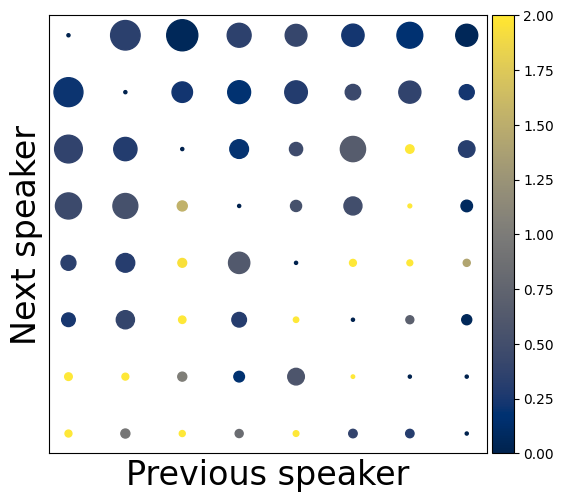

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Visualize the prediction results normalized
size_matrix = result_array   # Size values

color_matrix = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        if result_array[i,j] != 0:
            color_matrix[i,j] = abs(result_array[i,j] - model_array[i,j])/result_array[i,j]
#color_matrix = abs(result_array - model_array)        # Color values

# Create grid of positions
x, y = np.meshgrid(np.arange(8), np.arange(8))

# Flatten all for scatter plot
x_flat = x.flatten()
y_flat = y.flatten()

sizes = size_matrix.flatten()
size_min, size_max = 5, 500
size_norm = (size_matrix - size_matrix.min()) / (size_matrix.max() - size_matrix.min())
sizes = size_norm * (size_max - size_min) + size_min

colors = color_matrix.flatten()

vmin, vmax = 0.0, 2.0

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
scatter = ax.scatter(x_flat, y_flat, s=sizes, c=colors, cmap='cividis', vmin=vmin, vmax=vmax)
ax.invert_yaxis()  # Invert y-axis if you want it to look like matrix layout
ax.set_xticks(range(8))
ax.set_yticks(range(8))
ax.grid(True, linestyle='--', alpha=0.3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Previous speaker', fontsize=24)
ax.set_ylabel('Next speaker', fontsize=24)

ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(scatter, cax=cax)
plt.savefig("plots/MBC3_directtime_dot_relative.pdf", format='pdf', bbox_inches="tight")
plt.show()

In [158]:
#evaluation for single prediction
print(np.linalg.norm((result_array - model_array)))

mask = ~np.eye(8, dtype=bool)  # This creates a mask with False on the diagonal, True elsewhere

# Apply the mask and flatten
result_off_diag = result_array[mask]
model_off_diag = model_array[mask]

# Compute correlation
print(np.corrcoef(result_off_diag, model_off_diag))


#print(np.corrcoef(result_array.flatten(), model_array.flatten()))

0.07056059327972378
[[1.        0.8301758]
 [0.8301758 1.       ]]


### random null reciprocal

In [69]:
num_trail = 100
session_index = [0,2,4,6,7,8,9,10,11,14]
trans_matrix_turn_list = [[] for _ in range(num_trail)]
trans_matrix_time_list = [[] for _ in range(num_trail)]


name_dfs = []
name_dicts = []

for i in range(len(session_index)):
    session_id = session_index[i]
    df = pd.read_excel("NameMatch/MBC3_Name_Match_noreindex.xlsx", sheet_name=session_index[i])
    #df = pd.read_excel("NameMatch/AUT1_Name_Match.xlsx", sheet_name=session_index[i])
    #add speaking time information to df
    df['Name'] = df['First Name'] + ' ' + df['Last Name']
    name_dict = df.set_index('Order')['Name'].to_dict()
    name_dfs.append(df)
    name_dicts.append(name_dict)

combined_df = pd.concat(name_dfs, ignore_index=True)

states = combined_df['Name'].unique()

first_column = 'speaker_id'
second_column = 'prev_speaker_id'

for i in range(len(dfs)):
    tmp_combined_df = combine_turn(dfs[i])
    unique_labels = tmp_combined_df['speaker_id'].unique()
    
    for trail in range(num_trail):

        # Randomly assign new labels from the unique set
        tmp_combined_df['speaker_id'] = np.random.choice(unique_labels, size=len(tmp_combined_df))
        
        transition_df = turn_switch(tmp_combined_df)
        name_dict = name_dicts[i]

        tmp_states = name_dfs[i]['Name'].unique()
        tmp_transition_matrix_turn = pd.DataFrame(0, index=tmp_states, columns=tmp_states, dtype=float)
        tmp_transition_matrix_time = pd.DataFrame(0, index=tmp_states, columns=tmp_states, dtype=float)

        for j in range(len(transition_df)):
            current_state = transition_df[first_column].iloc[j] #'order'
            next_state = transition_df[second_column].iloc[j] #'order'
            if current_state in name_dict and next_state in name_dict:
                current_state = name_dict[current_state] #convert to 'name'
                next_state = name_dict[next_state] #convert to 'name'

                tmp_transition_matrix_turn.loc[current_state, next_state] += 1 #in transition matrix, the state is 'name'
                tmp_transition_matrix_time.loc[current_state, next_state] += transition_df.iloc[j]['duration']
                

        trans_matrix_turn_list[trail].append(tmp_transition_matrix_turn)
        trans_matrix_time_list[trail].append(tmp_transition_matrix_time)
        

In [70]:
#get 100 random prediction
random_trail_list = []
for trail in range(num_trail):
    random_array = np.zeros((N,N))
    for i in range(len(trans_matrix_time_list[trail])):
        tmp = trans_matrix_time_list[trail][i].to_numpy()
        row_sums = np.sum(tmp, axis=1)
        sorted_indices = np.argsort(row_sums)[::-1]
        sorted_array = tmp[np.ix_(sorted_indices, sorted_indices)]
        random_array += sorted_array[:N, :N]/np.sum(sorted_array[:N, :N])
    random_array = random_array/len(trans_matrix_time_list[trail])
    random_array = random_array/np.sum(random_array)
    random_trail_list.append(random_array)
    
    

In [71]:
random_rmse_error = random_trail_list - result_array
random_norms = np.linalg.norm(random_rmse_error, axis=(-2, -1))

norms_lower_bound = np.percentile(random_norms, 2.5)
norms_upper_bound = np.percentile(random_norms, 97.5)
norms_mean_bound = np.mean(random_norms)

print(norms_lower_bound, norms_mean_bound, norms_upper_bound)
print(norms_lower_bound - norms_mean_bound, norms_mean_bound - norms_upper_bound)

0.07889064611731797 0.09710229874040568 0.1128907609389455
-0.018211652623087715 -0.015788462198539813


In [149]:
random_corr = np.zeros((100,))
for i in range(100):
    
    mask = ~np.eye(8, dtype=bool)  # This creates a mask with False on the diagonal, True elsewhere

    # Apply the mask and flatten
    result_off_diag = result_array[mask]
    random_off_diag = random_trail_list[i][mask]

    # Compute correlation
    tmp_corr = np.corrcoef(result_off_diag, random_off_diag)[0, 1]
    
    #tmp_corr = np.corrcoef(result_array.flatten(), random_trail_list[i].flatten())
    random_corr[i] = tmp_corr

norms_lower_bound = np.percentile(random_corr, 2.5)
norms_upper_bound = np.percentile(random_corr, 97.5)
norms_mean_bound = np.mean(random_corr)

print(norms_lower_bound, norms_mean_bound, norms_upper_bound)
print(norms_lower_bound - norms_mean_bound, norms_mean_bound - norms_upper_bound)

0.5083568737397902 0.6469397070042288 0.7844522519248992
-0.13858283326443854 -0.13751254492067044


### Statistical Null

In [65]:
num_trail = 100
session_index = [0,2,4,6,7,8,9,10,11,14]
trans_matrix_turn_list = [[] for _ in range(num_trail)]
trans_matrix_time_list = [[] for _ in range(num_trail)]


name_dfs = []
name_dicts = []

for i in range(len(session_index)):
    session_id = session_index[i]
    df = pd.read_excel("NameMatch/MBC3_Name_Match_noreindex.xlsx", sheet_name=session_index[i])
    #df = pd.read_excel("NameMatch/AUT1_Name_Match.xlsx", sheet_name=session_index[i])
    #add speaking time information to df
    df['Name'] = df['First Name'] + ' ' + df['Last Name']
    name_dict = df.set_index('Order')['Name'].to_dict()
    name_dfs.append(df)
    name_dicts.append(name_dict)

combined_df = pd.concat(name_dfs, ignore_index=True)

states = combined_df['Name'].unique()

first_column = 'speaker_id'
second_column = 'prev_speaker_id'

for i in range(len(dfs)):
    tmp_combined_df = combine_turn(dfs[i])
    unique_labels = tmp_combined_df['speaker_id'].unique()
    
    time_distribution = []
    for k in range(len(unique_labels)):
        tmp_speaker_df = tmp_combined_df[tmp_combined_df['speaker_id']==unique_labels[k]]
        time_distribution.append(tmp_speaker_df['duration'].sum())
    time_distribution = np.array(time_distribution)
    time_distribution = time_distribution / sum(time_distribution)

    
    for trail in range(num_trail):
        # Randomly assign new labels from the unique set
        tmp_combined_df['speaker_id'] = np.random.choice(unique_labels, size=len(tmp_combined_df), p=time_distribution)
        
        transition_df = turn_switch(tmp_combined_df)
        name_dict = name_dicts[i]

        tmp_states = name_dfs[i]['Name'].unique()
        tmp_transition_matrix_turn = pd.DataFrame(0, index=tmp_states, columns=tmp_states, dtype=float)
        tmp_transition_matrix_time = pd.DataFrame(0, index=tmp_states, columns=tmp_states, dtype=float)

        for j in range(len(transition_df)):
            current_state = transition_df[first_column].iloc[j] #'order'
            next_state = transition_df[second_column].iloc[j] #'order'
            if current_state in name_dict and next_state in name_dict:
                current_state = name_dict[current_state] #convert to 'name'
                next_state = name_dict[next_state] #convert to 'name'

                tmp_transition_matrix_turn.loc[current_state, next_state] += 1 #in transition matrix, the state is 'name'
                tmp_transition_matrix_time.loc[current_state, next_state] += transition_df.iloc[j]['duration']
                

        trans_matrix_turn_list[trail].append(tmp_transition_matrix_turn)
        trans_matrix_time_list[trail].append(tmp_transition_matrix_time)

In [66]:
#get 100 statistical null prediction
stats_trail_list = []
for trail in range(num_trail):
    random_array = np.zeros((N,N))
    for i in range(len(trans_matrix_time_list[trail])):
        tmp = trans_matrix_time_list[trail][i].to_numpy()
        row_sums = np.sum(tmp, axis=1)
        sorted_indices = np.argsort(row_sums)[::-1]
        sorted_array = tmp[np.ix_(sorted_indices, sorted_indices)]
        random_array += sorted_array[:N, :N]/np.sum(sorted_array[:N, :N])
    random_array = random_array/len(trans_matrix_time_list[trail])
    random_array = random_array/np.sum(random_array)
    stats_trail_list.append(random_array)

In [67]:
stats_trail_list[7].sum(axis=1)

array([0.31647491, 0.21463048, 0.17413086, 0.11053823, 0.07639565,
       0.0535923 , 0.03808563, 0.01615194])

In [68]:
stats_rmse_error = stats_trail_list - result_array
stats_norms = np.linalg.norm(stats_rmse_error, axis=(-2, -1))

norms_lower_bound = np.percentile(stats_norms, 2.5)
norms_upper_bound = np.percentile(stats_norms, 97.5)
norms_mean_bound = np.mean(stats_norms)

print(norms_lower_bound, norms_mean_bound, norms_upper_bound)
print(norms_lower_bound - norms_mean_bound, norms_mean_bound - norms_upper_bound)

0.0771387965633454 0.09828080867529812 0.11989671228225009
-0.021142012111952727 -0.021615903606951967


### Reciprocal Prediction for each individual

In [97]:
outputdir = "pairsoutput/MBC3/"

filename = "MBC2_turns_forattendboth23.pkl"
    
with open(outputdir + filename, 'rb') as file:
    MBC2_turns = pickle.load(file)
    
session_index = [0,2,4,6,7,8,9,10,11,14]

dfs = []

# Define a function to match total speaking time
def add_time(order):
    try:
        return df_list[i].loc[order]["total_time"]
    except:
        return None

def add_turn(order):
    try:
        return df_list[i].loc[order]["total_turns"]
    except:
        return None

for i in range(len(session_index)):
    session_id = session_index[i]
    df = pd.read_excel("NameMatch/MBC3_Name_Match_noreindex.xlsx", sheet_name=session_index[i])
    #add speaking time information to df
    dfs.append(df)

valid_speaker = []
for i in range(len(dfs)):
    tmpdf = dfs[i]
    tmp = tmpdf[tmpdf["First Name"].isin(MBC2_turns["First Name"])]["Order"].dropna().astype('int').tolist()
    tmp_result = pd.merge(tmpdf, MBC2_turns, on="First Name", how="left")
    tmp_result["Index"] = tmp_result.index
    valid_speaker.append(tmp_result[['Name', 'Turns', 'Order','Index']].dropna())

In [100]:
valid_speaker[3]['Order'] = [8,3,1,6,9]
valid_speaker[7]['Order'] = [9,5,8,0]

In [118]:
session_index = [0,2,4,6,7,8,9,10,11,14]
trans_matrix_turn_list = []
trans_matrix_time_list = []


MBC2_combined_df = pd.concat(valid_speaker, ignore_index=True)

states = MBC2_combined_df['Name'].unique()
total_transition_matrix_turn = pd.DataFrame(0, index=states, columns=states, dtype=float)
total_transition_matrix_time = pd.DataFrame(0, index=states, columns=states, dtype=float)

first_column = 'speaker_id'
second_column = 'prev_speaker_id'

for i in range(len(dfs)):
    tmp_combined_df = combine_turn(dfs[i])
    transition_df = turn_switch(tmp_combined_df)
    name_dict = name_dicts[i]
    
    tmp_states = valid_speaker[i]['Name'].unique()
    tmp_transition_matrix_turn = pd.DataFrame(0, index=tmp_states, columns=tmp_states, dtype=float)
    tmp_transition_matrix_time = pd.DataFrame(0, index=tmp_states, columns=tmp_states, dtype=float)
    
    for j in range(len(transition_df)):
        current_state = transition_df[first_column].iloc[j] #'order'
        next_state = transition_df[second_column].iloc[j] #'order'
        if current_state in name_dict and next_state in name_dict:
            current_state = name_dict[current_state] #convert to 'name'
            next_state = name_dict[next_state] #convert to 'name'
            
            if current_state in tmp_states and next_state in tmp_states:
        
                tmp_transition_matrix_turn.loc[current_state, next_state] += 1 #in transition matrix, the state is 'name'
                tmp_transition_matrix_time.loc[current_state, next_state] += transition_df.iloc[j]['duration']
                total_transition_matrix_turn.loc[current_state, next_state] += 1
                total_transition_matrix_time.loc[current_state, next_state] += transition_df.iloc[j]['duration']
    
    trans_matrix_turn_list.append(tmp_transition_matrix_turn)
    trans_matrix_time_list.append(tmp_transition_matrix_time)

In [135]:
## reciporcal time model prediction


session_index = [0,2,4,6,7,8,9,10,11,14]


MBC2_combined_df = pd.concat(valid_speaker, ignore_index=True)

states = MBC2_combined_df['Name'].unique()

model_total_transition_matrix_time = pd.DataFrame(0, index=states, columns=states, dtype=float)


for j,i in enumerate(session_index):
    turn_df = pd.read_csv('Data/reciprocal_predtime_MBC3/'+str(i)+'.csv',header=None)
    name_list = pd.read_excel("Data/prediction/MBC3/MBC3_powerlaw_result_withid.xlsx", sheet_name=session_index[j])
    labels = name_list['Name'].to_list()
    turn_df.columns = labels
    turn_df.index = labels
    
    for name1 in labels:
        for name2 in labels:
            if name1 in states and name2 in states:
                model_total_transition_matrix_time.loc[name2][name1] = turn_df.loc[name2][name1]
        
    
    


In [144]:
real_total_transition_matrix_time = total_transition_matrix_time / total_transition_matrix_time.values.sum()
real_total_transition_matrix_time = real_total_transition_matrix_time.values
model_total_transition_matrix_time = model_total_transition_matrix_time.values

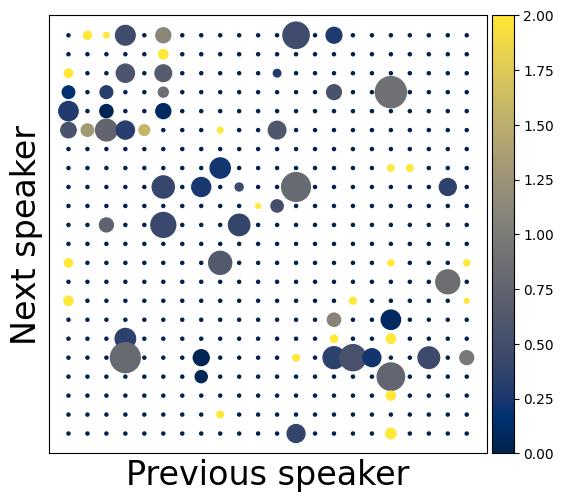

In [146]:
size_matrix = real_total_transition_matrix_time   # Size values

color_matrix = np.zeros((22,22))
for i in range(22):
    for j in range(22):
        if real_total_transition_matrix_time[i,j] != 0:
            color_matrix[i,j] = abs(real_total_transition_matrix_time[i,j] - model_total_transition_matrix_time[i,j])/real_total_transition_matrix_time[i,j]
#color_matrix = abs(result_array - model_array)        # Color values

# Create grid of positions
x, y = np.meshgrid(np.arange(22), np.arange(22))

# Flatten all for scatter plot
x_flat = x.flatten()
y_flat = y.flatten()

sizes = size_matrix.flatten()
size_min, size_max = 5, 500
size_norm = (size_matrix - size_matrix.min()) / (size_matrix.max() - size_matrix.min())
sizes = size_norm * (size_max - size_min) + size_min

colors = color_matrix.flatten()

vmin, vmax = 0.0, 2.0

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
scatter = ax.scatter(x_flat, y_flat, s=sizes, c=colors, cmap='cividis', vmin=vmin, vmax=vmax)
ax.invert_yaxis()  # Invert y-axis if you want it to look like matrix layout
ax.set_xticks(range(22))
ax.set_yticks(range(22))
ax.grid(True, linestyle='--', alpha=0.3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Previous speaker', fontsize=24)
ax.set_ylabel('Next speaker', fontsize=24)

ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(scatter, cax=cax)
plt.savefig("plots/MBC3_returnspeaker_dot_relative.pdf", format='pdf', bbox_inches="tight")
plt.show()

In [ ]:
## TODO
## Prediction from previous year


In [ ]:
## TODO
## Random prediction
